# 02 - Evaluate the Impact of Strong Convexity on Static Regret

**Claim under test:**  
Static component scales like G^2/λ when other factors are fixed.

**Grid file:** `grids/02_strong_convexity.yaml`

**Baseline & conventions**
- Use the STAR schema built by `experiment/utils/duck-db-loader.py`.
- Slice results by `(grid_id, seed)` using `analytics.v_run_summary`.
- Keep plots identical across notebooks; only the *dial* under test changes.

## 0) Imports & paths

In [1]:
from pathlib import Path
import duckdb
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# go up one level
os.chdir("..")

# project paths (edit if your repo layout differs)
REPO = Path(".").resolve()
RESULTS_GLOB = "results_parquet/02_strong_convexity/events/grid_id=*/seed=*/*.parquet"  # corrected pattern
DB_PATH = REPO/"artifacts"/"star.duckdb"
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

GRID_FILE = REPO/"grids/02_strong_convexity.yaml"     # this notebook’s grid
STAGING_TABLE = "staging.events"   # keep default from loader

## 1) Build/load the STAR schema

In [2]:
from utils.duck_db_loader import load_star_schema

con = load_star_schema(
    input_path=str(RESULTS_GLOB),
    db_path=str(DB_PATH),
    staging_table=STAGING_TABLE,
    run_ddl=True,
    create_events_view=True,
)

# sanity: counts
display(con.execute("""
SELECT 'dim_run' t, COUNT(*) c FROM analytics.dim_run
UNION ALL SELECT 'fact_event', COUNT(*) FROM analytics.fact_event
UNION ALL SELECT 'dim_event_type', COUNT(*) FROM analytics.dim_event_type
""").df())

Found 15 files matching pattern: results_parquet/02_strong_convexity/events/grid_id=*/seed=*/*.parquet
  ffc65ff3ff9e47a69692c002f88b035b-0.parquet: 75 columns
  c9f7530abf414678b01f97f3fe16c4fa-0.parquet: 75 columns
  4215672c2a8c4b5aa0105255a3bfff7f-0.parquet: 75 columns
  5ee7e0b4b2d24de89dda383362c3d56d-0.parquet: 75 columns
  7d916a6adadd4b978eb8272ece4ec39a-0.parquet: 75 columns
  8a6501e4d65b4894807fec3817a4ce47-0.parquet: 75 columns
  5dca218ac4294b2d8ec7c1aa35978aeb-0.parquet: 75 columns
  444174cf1a48469195c0cc111e39eccf-0.parquet: 75 columns
  c53af1b723b741aca939f3fe8a2969b6-0.parquet: 75 columns
  137864933b804c5bb9c279eb432c060e-0.parquet: 75 columns
  5a5637e6791c4583b27aa16ad86a82cd-0.parquet: 75 columns
  7561e46863db4f64b9547c15201213d1-0.parquet: 75 columns
  f9220759bf7e4d2fb8261c15a9cb3892-0.parquet: 75 columns
  a25068d7dcd54d378274021178fc0a5e-0.parquet: 75 columns
  2ac4ce135c8b4ba7a52cf3d86977f212-0.parquet: 75 columns
Total unique columns discovered: 75
All co

,t,c
0,dim_run,15
1,fact_event,149250
2,dim_event_type,4


## 2) Snapshot config & runs

In [3]:
# show the grid dictionary if kept in YAML (optional)
try:
    import yaml, textwrap
    cfg = yaml.safe_load(Path(GRID_FILE).read_text())
    print("grid file:", GRID_FILE)
    print(json.dumps(cfg.get("matrix", {}), indent=2))
except Exception as e:
    print("Note: could not parse YAML grid:", e)

runs = con.execute("""
SELECT *
FROM analytics.v_run_summary
ORDER BY grid_id, seed
""").df()
runs.head()

grid file: /workspaces/unlearning-research-meta/experiment/grids/02_strong_convexity.yaml
{
  "gamma_delete": [
    1.75
  ],
  "gamma": [
    1.0
  ],
  "lambda_reg": [
    0.05
  ],
  "lambda_": [
    0.05,
    0.1,
    0.2
  ],
  "rho_total": [
    1.5
  ],
  "delta_b": [
    0.1
  ],
  "target_G": [
    2.0
  ],
  "target_D": [
    2.0
  ],
  "target_c": [
    0.05
  ],
  "target_C": [
    20.0
  ],
  "target_lambda": [
    0.05
  ],
  "target_PT": [
    30.0
  ],
  "target_ST": [
    200000.0
  ],
  "path_style": [
    "rotating"
  ],
  "dim": [
    20
  ],
  "T": [
    50000
  ],
  "accountant": [
    "zcdp"
  ],
  "seed": [
    42
  ]
}


,grid_id,seed,run_id,total_events,insert_events,delete_events,avg_regret,min_regret,max_regret,avg_acc,...,max_rho_step,avg_rho_spent,min_rho_spent,max_rho_spent,avg_sigma_step,min_sigma_step,max_sigma_step,avg_sigma_delete,min_sigma_delete,max_sigma_delete
0,0e5790c1d8d6,0,0e5790c1d8d6_0,9950,8340.0,833.0,0.288802,-2.919341,10.349067,0.892674,...,1.5,0.0,0.0,0.0,340.667579,340.667579,340.667579,340.667579,340.667579,340.667579
1,0e5790c1d8d6,1,0e5790c1d8d6_1,9950,8470.0,847.0,0.533353,-1.754265,11.154050,0.968910,...,1.5,0.0,0.0,0.0,346.372267,346.372267,346.372267,346.372267,346.372267,346.372267
2,0e5790c1d8d6,2,0e5790c1d8d6_2,9950,8495.0,849.0,0.573120,-2.856246,18.703532,1.088198,...,1.5,0.0,0.0,0.0,358.165918,358.165918,358.165918,358.165918,358.165918,358.165918
3,0e5790c1d8d6,3,0e5790c1d8d6_3,9950,8480.0,847.0,0.140496,-5.543039,10.469811,0.966003,...,1.5,0.0,0.0,0.0,305.317532,305.317532,305.317532,305.317532,305.317532,305.317532
4,0e5790c1d8d6,4,0e5790c1d8d6_4,9950,8489.0,848.0,0.243134,-4.389611,8.278015,0.982851,...,1.5,0.0,0.0,0.0,361.518316,361.518316,361.518316,361.518316,361.518316,361.518316


## 3) Standard query helpers

In [4]:
def last_event_frame(con, grid_id:str, seed:int):
    return con.execute("""
    WITH last AS (
      SELECT MAX(event_id) AS last_id
      FROM analytics.fact_event fe
      WHERE fe.grid_id = ? AND fe.seed = ?
    )
    SELECT fe.*
    FROM analytics.fact_event fe
    CROSS JOIN last l
    WHERE fe.event_id = l.last_id AND fe.grid_id = ? AND fe.seed = ?
    """, [grid_id, seed, grid_id, seed]).df()

def trace_frame(con, grid_id:str, seed:int, cols:tuple[str,...]):
    col_list = ", ".join(cols)
    return con.execute(f"""
    SELECT event_id, {col_list}
    FROM analytics.fact_event fe
    WHERE fe.grid_id = ? AND fe.seed = ?
    ORDER BY event_id
    """, [grid_id, seed]).df()

## 4) Plots (standardized)
Keep styling consistent across notebooks for visual comparability.

In [5]:
def plot_traces(df, ycols, title):
    for y in ycols:
        plt.figure()
        plt.plot(df["event_id"], df[y], label=y)
        plt.xlabel("event_id"); plt.ylabel(y); plt.title(f"{title}: {y}")
        plt.legend(); plt.show()

## 5) Notebook-specific check: claim, dial, metrics

Claim under test: Static component scales like G^2/λ when other factors are fixed.
Example run: 0e5790c1d8d6 0


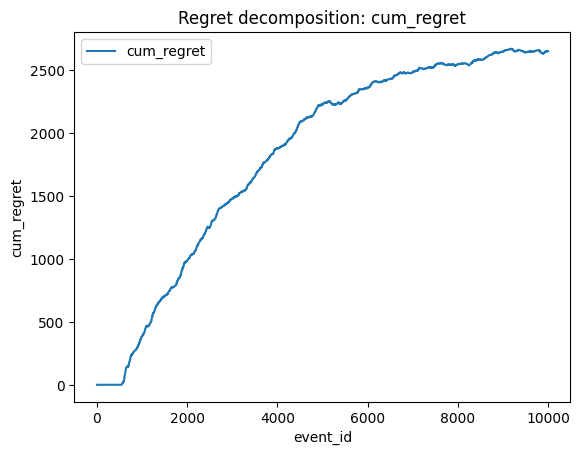

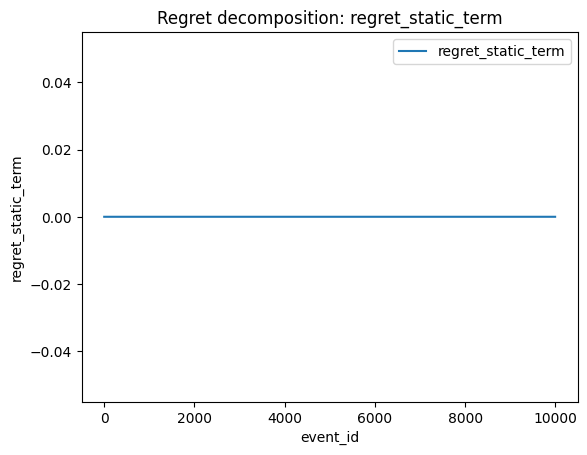

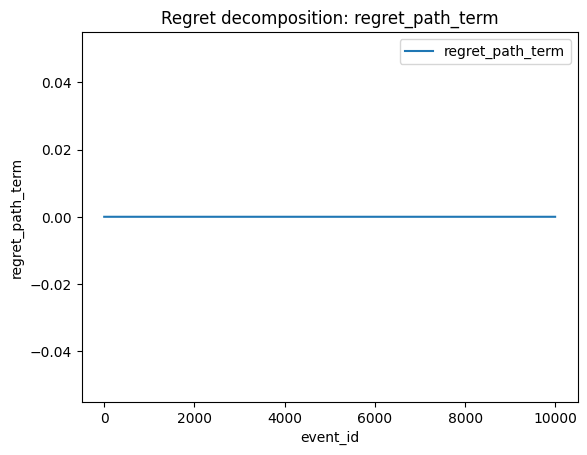

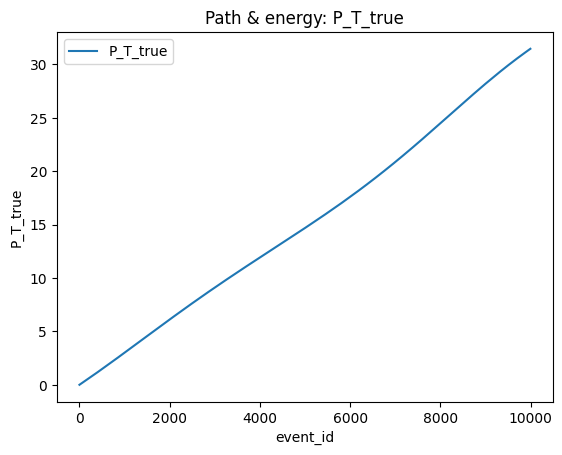

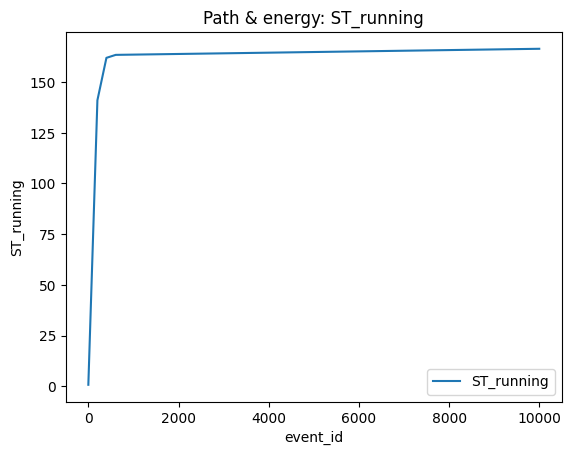

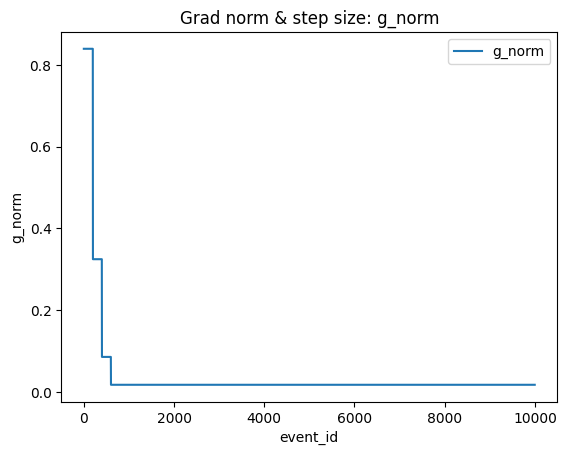

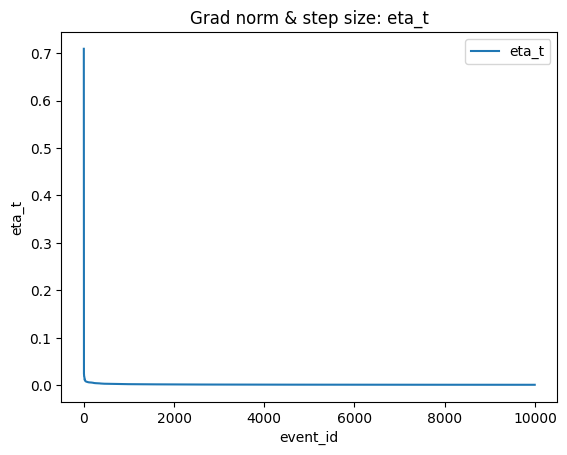

,cum_regret,cum_regret_with_noise,P_T_true,ST_running,rho_spent,m_used
0,2653.118359,2653.118359,31.466027,166.448231,0.0,0


In [6]:
NOTEBOOK_CLAIM = "Static component scales like G^2/λ when other factors are fixed."
print("Claim under test:", NOTEBOOK_CLAIM)

# choose a (grid_id, seed) to visualize (edit if multiple)
if not runs.empty:
    gid, seed = runs.loc[0, ["grid_id","seed"]]
    print("Example run:", gid, seed)

    # universal traces
    df = trace_frame(con, gid, int(seed), (
        "cum_regret", "regret_static_term", "regret_path_term",
        "P_T_true", "ST_running", "g_norm", "eta_t"
    ))
    plot_traces(df, ["cum_regret","regret_static_term","regret_path_term"], "Regret decomposition")
    plot_traces(df, ["P_T_true","ST_running"], "Path & energy")
    plot_traces(df, ["g_norm","eta_t"], "Grad norm & step size")

    # end-of-run snapshot
    tail = last_event_frame(con, gid, int(seed))
    display(tail[["cum_regret","cum_regret_with_noise","P_T_true","ST_running","rho_spent","m_used"]])

## 6) One-page “claim check” (export)
Emits a compact JSON summary to artifacts/ for CI diffs.

In [7]:
ARTIFACT = REPO/"artifacts"/(Path("02_strong_convexity_vs_static_regret.ipynb").stem + "_claim_check.json")
ARTIFACT.parent.mkdir(parents=True, exist_ok=True)

summary = con.execute("""
SELECT
  dr.grid_id, dr.seed,
  MAX(fe.cum_regret) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_cum_regret,
  MAX(fe.cum_regret_with_noise) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_cum_regret_with_noise,
  MAX(fe.P_T_true) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_P_T_true,
  MAX(fe.ST_running) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_ST_running,
  MAX(fe.rho_spent) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_rho_spent,
  MAX(fe.m_used) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event WHERE grid_id = fe.grid_id AND seed = fe.seed)) AS final_m_used
FROM analytics.fact_event fe
JOIN analytics.dim_run dr USING (grid_id, seed)
GROUP BY dr.grid_id, dr.seed
ORDER BY dr.grid_id, dr.seed
""").df().to_dict(orient="records")

ARTIFACT.write_text(json.dumps({
    "notebook": "02_strong_convexity_vs_static_regret.ipynb",
    "claim": NOTEBOOK_CLAIM,
    "grid_file": str(GRID_FILE),
    "summary": summary
}, indent=2))
print("Wrote:", ARTIFACT)

Wrote: /workspaces/unlearning-research-meta/experiment/artifacts/02_strong_convexity_vs_static_regret_claim_check.json
